# Scraping Pipeline

This jupyter notebook contains a full pipeline for scraping Digico's website and extracting all the text information contained in the website for obtaining a clean data context that will be used for building our RAG system 

## Motivation : 

I noticed that each page of the website is composed of a series of <div class="elementor-element>  

So I started to scrape each page based on the divisions it is composed of 

This will extract the text content of each division and agglomerate it together

This will provide a more a more compact context for RAG 

But that’s not everything, in the following we will discover the end-to-end pipeline I implemented to get the cleanest information possible

## Loading dependencies

In [1]:
import requests
from bs4 import BeautifulSoup
import os
from dotenv import load_dotenv

## Configuration

This cell:

- loads the base domain from .env 
-  sets the START_URL (the page from where we will start crawling)
- Headers are key-value pairs sent with HTTP requests and responses that   convey metadata, such as the user agent, content type, or authentication tokens and make the web scraper's requests appear to come from a legitimate Chrome browser

In [2]:
load_dotenv()
BASE_DOMAIN = os.getenv('BASE_DOMAIN')
START_URL = f"{BASE_DOMAIN}" # start crawling from https://digico.solutions/

# URLs to skip entirely because it displays the same info as https://digico.solutions/
SKIP_URLS = {"https://digico.solutions/solutions/"}


HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/119.0.0.0 Safari/537.36"
}

## Creating a whitelist of anchors 
Some URLs have anchors 
example :  
https://digico.solutions/solutions/cloud-consulting-and-migration/#lift-and-shift

so we are extracting the same information twice :
- once for https://digico.solutions/solutions/cloud-consulting-and-migration/
- also for https://digico.solutions/solutions/cloud-consulting-and-migration/#lift-and-shift

So to avoid redundancy I decided to get rid of all the anchors except for the defined _WHITELIST because the information inside of these URLs does not show up in the scraping output without the anchors 

In [3]:
ANCHOR_WHITELIST = {
    "https://digico.solutions/company/about-us/#lqd-tabs-content-c679098-c679098",
    "https://digico.solutions/company/about-us/#lqd-tabs-content-99d6f0c-99d6f0c",
    "https://digico.solutions/company/about-us/#lqd-tabs-content-5806aa6-5806aa6",
}

## Get rid of hidden elements in each page 
some pages contain hidden elements these elements could be :
- features that are still not approved
- elements that should be hidden based on the display (phone, tablet, desktop ... )

This creates noisy information that may affect the performance of our RAG system

In [4]:
HIDDEN_SELECTORS = [
    "[hidden]",
    "[inert]",
    '[aria-hidden="true"]',
    ".elementor-hidden-desktop",
]

## Get rid of unwanted selectors 
many components of the pages present no useful context  :
- read more buttons
- ai-discovery-card
- lqd-marquee-cell <- example : transitionned expressions in the background 
- assessment forms

So I selected these noisy parts in the following list that I have built through lot of iterations and by picking each part specifically

In [5]:
UNWANTED_SELECTORS = [
    "span.eael_load_more_text",
    "a.eael-post-elements-readmore-btn",
    "span.elementor-button-text",
    "span.lqd-btn-txt",
    "a.text-inherit",
    "div.ai-discovery-card",
    "div.readiness-assessment-dialog-overlay.active",
    "div.data-readiness-assessment-dialog-overlay.active",
    "div.cloud-readiness-assessment-dialog-overlay.active",
    "div.lqd-marquee-cell",
    "code"
]


In [6]:
# this function will use HIDDEN_SELECTORS & UNWANTED_SELECTORS lists to get rid of hidden and unwanted selectors
def remove_hidden_and_unwanted(soup_copy):
    for selector in HIDDEN_SELECTORS + UNWANTED_SELECTORS:
        for tag in soup_copy.select(selector):
            tag.decompose()
    return soup_copy

## extract_blocks(soup)
This function uses Beautiful soup to parse the html to extract the text content while taking into consideration : 
- excluding nav and footer text info
- remove hidden and unwanted information
- replace Elementor counters with final value
- extract blocks of text based on div.elementor-element

In [7]:
def extract_blocks(soup):
    soup_copy = BeautifulSoup(str(soup), 'lxml')

    # Remove nav and footer elements because they present no  useful content
    for tag in soup_copy.find_all(["nav", "footer"]):
        tag.decompose()

    # Apply unified hidden + unwanted removal
    soup_copy = remove_hidden_and_unwanted(soup_copy)

    """
    Replace Elementor counters with final value : 
    Some pages contain some value counters that load dynamically resulting in 0 % in the output 
    """
    for counter in soup_copy.select("span.elementor-counter-number"):
        counter.string = counter.get("data-to-value", counter.text.strip())

    # Extract blocks of text
    blocks = []
    for div in soup_copy.find_all("div", class_="elementor-element"):
        text = div.get_text(separator=" ", strip=True)
        if text:
            blocks.append(text)
    return blocks


## extract_links(soup)

Extracting links from each page is a crucial step because the crawling function will automatically open each link and scrape its content so the function extract_links(soup) does this task : 
- extracts the content of href from each <a> hyperlink inside the page and concatenate it with BASE_DOMAIN to obtain a url that is ready to call 
- gets rid of the links that display arabic content (links that contain /ar)
- filters the links containing anchors, if they belong to ANCHOR_WHITELIST it keeps them, else it gets rid of the anchor part and keeps the rest of the link  

In [8]:
def extract_links(soup):
    soup_copy = BeautifulSoup(str(soup), 'lxml')
    soup_copy = remove_hidden_and_unwanted(soup_copy)

    links = []
    for a in soup_copy.find_all("a", href=True):
        href = a['href']
        if not href.startswith(BASE_DOMAIN):
            continue
        if "/ar" in href:
            continue
        if href in ANCHOR_WHITELIST:
            clean_href = href
        else:
            clean_href = href.split("#")[0]
        links.append(clean_href)
    return list(dict.fromkeys(links))

In [9]:
# function that removes the duplicates from the output file and keeps only the unique text sentences in order to avoid redundancy of information 
def remove_duplicates(text_blocks):
    unique_blocks = []
    for block in text_blocks:
        if not any(block in other for other in unique_blocks):
            unique_blocks.append(block)
    return unique_blocks

Previously the crawler avoids duplicates only if the URLs are literally identical (string match).
But in this  example:

* `https://digico.solutions/solutions/migration-services/`
* `https://digico.solutions/solutions/cloud-consulting-and-migration/migration-services/`

Both return the same content (because the site uses a canonical URL), but the crawler treats them as two separate pages.



* A canonical URL is defined in the <head> of the HTML:

  ```html
  <link rel="canonical" href="https://digico.solutions/solutions/migration-services/"/>
  ```

* Crawlers should use the **canonical href** instead of the requested URL to avoid duplicates.

We need to normalize each page’s URL by checking if it has a canonical tag and using that instead of the raw `url`.



In [27]:
def get_canonical_url(soup, current_url):
    """Extract canonical URL from the page <head>, fallback to current URL."""
    link_tag = soup.find("link", rel="canonical")
    if link_tag and link_tag.get("href"):
        return link_tag["href"].strip()
    return current_url


## crawl(url, depth, max_depth, visited, output_file)\

This function scrapes the whole website recursively : 
 - The intuition behind the crawl function is using DFS , but why ? 

    - In DFS we visit a node (a page) and visit all its descendant pages before moving to another node and doing visiting all its descendants
 
    - After applying chunking with overlapping we can achieve the following benifits : 
 
            - Preserving Semantic Context: It prevents ideas, entities, and narratives from being abruptly cut off. This is crucial for understanding the relationship between concepts that span multiple sentences or paragraphs.
 
            - Improving Retrieval Relevance: By ensuring that key information appears in multiple chunks (with slightly different surrounding context), you increase the probability that the retriever will find at least one chunk that is highly relevant to the user's query. It acts as a safety net.
 
            - Enhancing Answer Quality and Coherence: When the LLM (the Generator) receives chunks that have preserved their original context, it can generate answers that are more accurate, comprehensive, and logically consistent. It avoids generating answers based on fragmented information.
 
 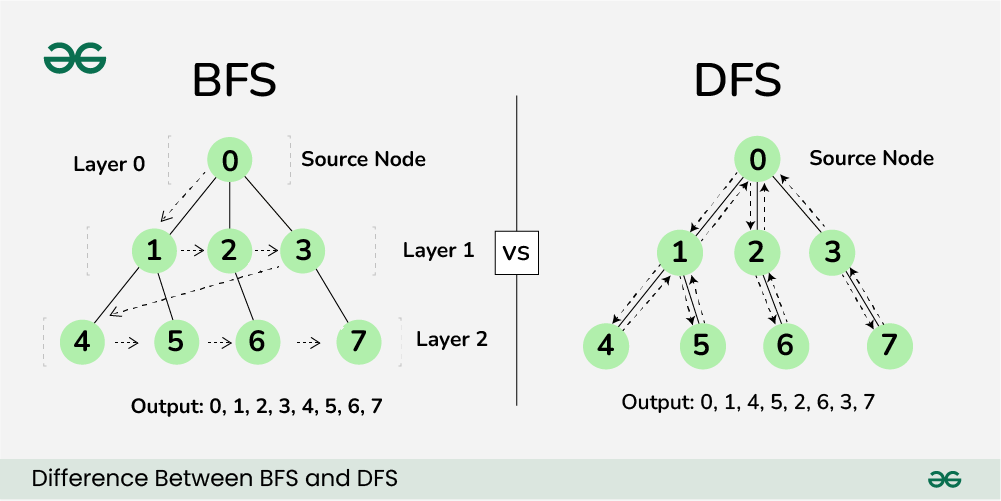

In [29]:
def crawl(url, depth, max_depth, visited, output_file):
    if depth > max_depth or url in visited or url in SKIP_URLS:
        return
    
    print(f"Crawling (depth {depth}): {url}")

    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            print(f"Failed to fetch {url}: Status code {response.status_code}")
            return
        soup = BeautifulSoup(response.text, 'lxml')
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return

    # ✅ Normalize with canonical URL
    canonical_url = get_canonical_url(soup, url)

    # Skip if canonical already visited or in SKIP_URLS
    if canonical_url in visited or canonical_url in SKIP_URLS:
        print(f"Skipping duplicate (canonical): {canonical_url}")
        return

    # Mark canonical URL as visited
    visited.add(canonical_url)

    # Extract per-page blocks and links
    blocks = extract_blocks(soup)
    unique_blocks = remove_duplicates(blocks)
    links = extract_links(soup)

    # Incrementally write this page to output file
    with open(output_file, "a", encoding="utf-8") as f:
        f.write(f"\n=== PAGE: {canonical_url} ===\n")
        f.write("=== TEXT ===\n")
        f.write("\n".join(unique_blocks))
        f.write("\n\n=== LINKS ===\n")
        f.write("\n".join(links))
        f.write("\n\n")

    # Recurse into links
    for link in links:
        crawl(link, depth + 1, max_depth, visited, output_file)

In [33]:
# --- Run Crawler ---
if __name__ == "__main__":
    visited = set()
    output_file = "./scraped_data/crawling_raw_output.txt"

    # Clear previous file
    open(output_file, "w", encoding="utf-8").close()

    MAX_DEPTH = 10  # starting page is depth 0
    crawl(START_URL, depth=0, max_depth=MAX_DEPTH, visited=visited, output_file=output_file)

    print(f"\nRecursive crawling finished. Output saved to '{output_file}'.")

Crawling (depth 0): https://digico.solutions/
Crawling (depth 1): https://digico.solutions/solutions/cloud-consulting-and-migration/
Crawling (depth 2): https://digico.solutions/solutions/cloud-modernization/
Crawling (depth 3): https://digico.solutions/solutions/managed-services/
Crawling (depth 4): https://digico.solutions/solutions/data-analytics/
Crawling (depth 5): https://digico.solutions/solutions/data-analytics/
Skipping duplicate (canonical): https://digico.solutions/solutions/data-and-analytics/
Crawling (depth 5): https://digico.solutions/solutions/startup-hub/
Crawling (depth 6): https://digico.solutions/solutions/data-analytics/
Skipping duplicate (canonical): https://digico.solutions/solutions/data-and-analytics/
Crawling (depth 6): https://digico.solutions/ai-assessment/
Crawling (depth 7): https://digico.solutions/solutions/data-analytics/
Skipping duplicate (canonical): https://digico.solutions/solutions/data-and-analytics/
Crawling (depth 7): https://digico.solutions/

## Cleaning the raw crawling data

This function clean_crawling_data(input_file, output_file) cleans the crawling data by removing: 

- page headers
- section markers
- links
- the ☁️ emoji
- add “.” to the end of each paragraph and properly handles paragraph breaks for keeping the structure : each page is contained into one paragraph (this will help with chunking in case we are using RecursiveCharacterTextSplitter) .
- skips the content of the page privacy-policy because it provides information with little importance

In [ ]:
def clean_crawling_data(input_file, output_file):
    """
    Clean the crawling data by removing the PAGE section for privacy-policy,
    along with section markers, links, empty lines, and the ☁️ emoji.
    Also ensures each paragraph ends with a period if it does not already.
    """
    TARGET_PAGE = "=== PAGE: https://digico.solutions/privacy-policy/ ==="
    
    try:
        with open(input_file, 'r', encoding='utf-8') as infile:
            lines = infile.readlines()
        
        cleaned_lines = []
        in_text_section = False
        skip_section = False
        skip_current_page = False   # <--- flag to skip only the privacy-policy page
        
        for line in lines:
            line = line.strip()
            
            # If this is the target PAGE header, skip until next PAGE
            if line == TARGET_PAGE:
                skip_current_page = True
                continue
            elif line.startswith("=== PAGE:") and skip_current_page:
                skip_current_page = False  # stop skipping when a new PAGE starts
            
            # While skipping, ignore everything
            if skip_current_page:
                continue
            
            # Enter TEXT section
            if line == '=== TEXT ===':
                in_text_section = True
                skip_section = False
                continue
            
            # Enter LINKS section (skip everything)
            elif line == '=== LINKS ===':
                in_text_section = False
                skip_section = True
                continue
            
            # Skip all links
            elif line.startswith('http'):
                continue
            
            # If in text section and not skipping
            elif in_text_section and not skip_section:
                cleaned_line = line.replace('☁️', '').replace('*', '').replace('~', '').replace('×', '').replace('=', '').replace('*', '')
                
                if cleaned_line.strip() == "":
                    cleaned_lines.append("")
                else:
                    cleaned_lines.append(cleaned_line.strip())
        
        # Write cleaned output
        with open(output_file, 'w', encoding='utf-8') as outfile:
            prev_blank = False
            for line in cleaned_lines:
                if line.strip():
                    if not line.endswith(('.', '!', '?', '…')):
                        line += '.'
                    outfile.write(line + '\n')
                    prev_blank = False
                else:
                    if not prev_blank:
                        outfile.write('\n')
                    prev_blank = True
    
    except FileNotFoundError:
        print(f"Error: Input file '{input_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Usage
input_filename = './scraped_data/crawling_raw_output.txt'
output_filename = './scraped_data/cleaned_text_content.txt'

clean_crawling_data(input_filename, output_filename)